In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


The dataset includes training and test cases where each case is labeled from 0 to 25, representing the letters A-Z (excluding J and Z) as they require motion, also in csv files each pixels are included each row inclued a single image there are(27,455 cases) and test data (7172 cases) total (28x28x1 =784) pixels are there.

The 24 classes represent:


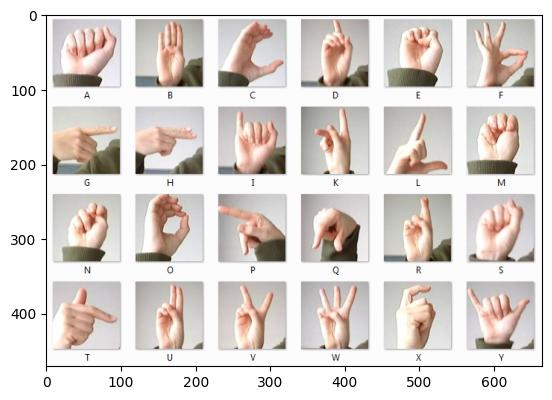

In [19]:
import matplotlib.image as mpimg
print("The 24 classes represent:")
img = mpimg.imread('/content/drive/MyDrive/FINAL/download.png')  # replace with your image path
imgplot = plt.imshow(img)
plt.show()

In [20]:
train_df = pd.read_csv("/content/drive/MyDrive/FINAL/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/FINAL/sign_mnist_test.csv")

print("Number of images in training dataset:",train_df.shape[0])
print("Number of images in test dataset",test_df.shape[0])

Number of images in training dataset: 27455
Number of images in test dataset 7172


In [21]:
print(train_df.head(10))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   
5     16     161     168     172     173     178     184     189     193   
6      8     134     134     135     135     136     137     137     138   
7     22     114      42      74      99     104     109     117     127   
8      3     169     174     176     180     183     185     187     188   
9      3     189     189     189     190     190     191     190     190   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     1

In [22]:
y_train = train_df['label']
y_test = test_df['label']
train_df.drop(columns=['label'], inplace=True)
test_df.drop(columns=['label'], inplace=True)

LabelBinarizer is a scikit-learn preprocessing technique used for converting categorical labels into a binary matrix (or one-hot encoding). This is typically used when you have a multi-class classification problem, and you want to convert class labels into a format that can be used by machine learning algorithms.

In [23]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [24]:
x_train = train_df.values / 255.0
x_test = test_df.values / 255.0

In [25]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [26]:
x_train_resized = np.array([cv2.resize(img, (64, 64)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (64,64)) for img in x_test])

In [27]:
print("x_train_resized shape:", x_train_resized.shape)
print("x_test_resized shape:", x_test_resized.shape)

x_train_resized shape: (27455, 64, 64)
x_test_resized shape: (7172, 64, 64)


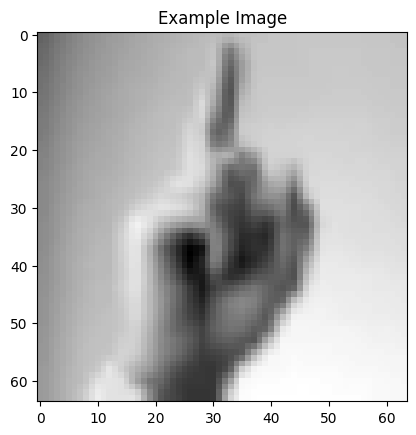

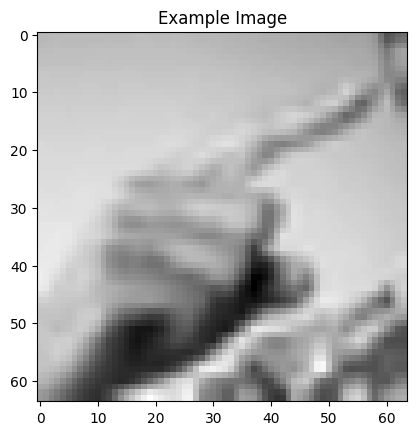

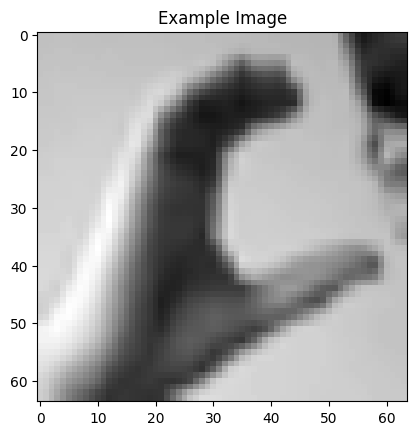

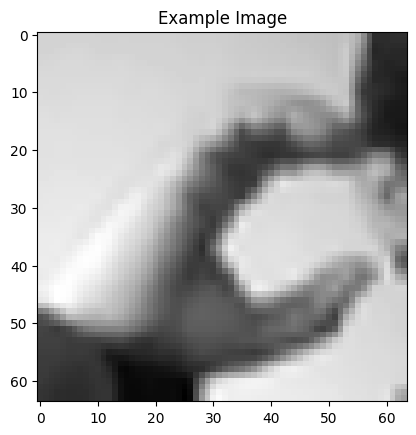

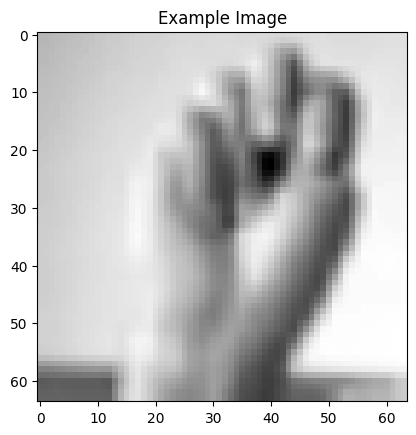

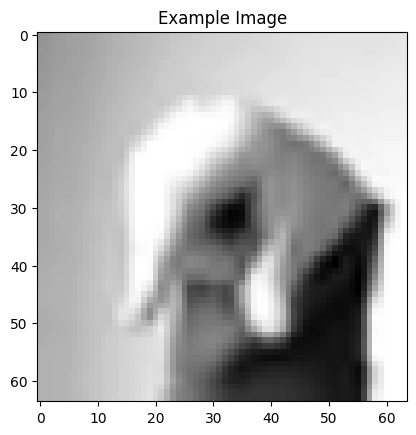

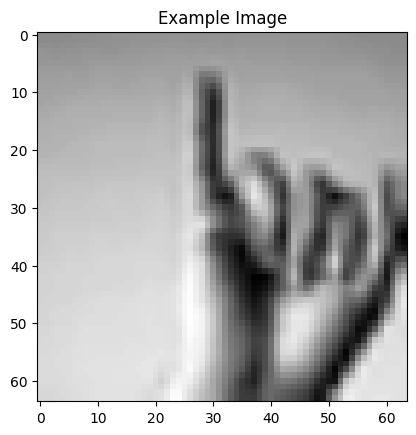

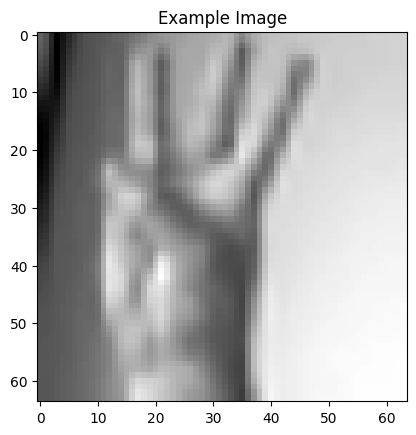

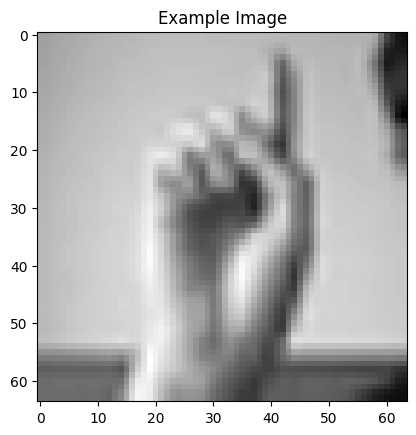

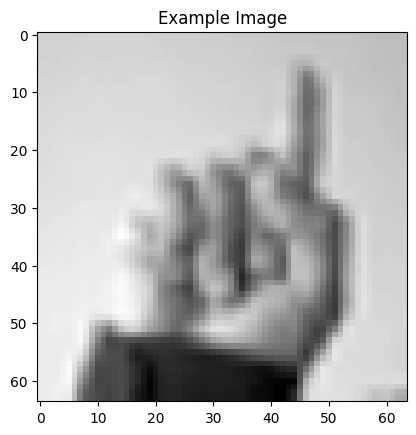

In [28]:
for i in range(10):
    image_to_display = x_train_resized[i] * 255.0
    image_to_display = image_to_display.astype('uint8').reshape(64,64)
    plt.imshow(image_to_display, cmap='gray')
    plt.title("Example Image")
    plt.show()

In [29]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(24, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 50)       

In [30]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [31]:
history = model.fit(x_train_resized, y_train, batch_size=32, epochs=50, validation_data=(x_test_resized, y_test),callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/50
858/858 [==============================] - 18s 16ms/step - loss: 1.3047 - accuracy: 0.8365 - val_loss: 0.9703 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/50
858/858 [==============================] - 16s 19ms/step - loss: 0.5608 - accuracy: 0.9773 - val_loss: 1.1689 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 3/50
858/858 [==============================] - 14s 16ms/step - loss: 0.5194 - accuracy: 0.9753 - val_loss: 1.4088 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/50
858/858 [==============================] - 14s 17ms/step - loss: 0.4679 - accuracy: 0.9846 - val_loss: 1.5985 - val_accuracy: 0.6753 - lr: 0.0010
Epoch 5/50
858/858 [==============================] - 13s 16ms/step - loss: 0.4616 - accuracy: 0.9821 - val_loss: 1.1613 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 6/50
858/858 [==============================] - 13s 16ms/step - loss: 0.4851 - accuracy: 0.9846 - val_loss: 0.7267 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 7/50
858/858 [==============================] - 13s 

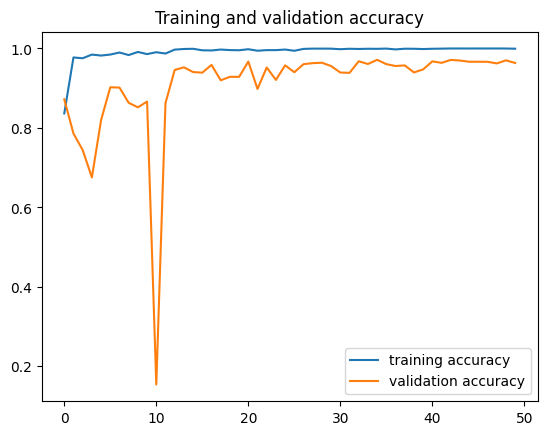

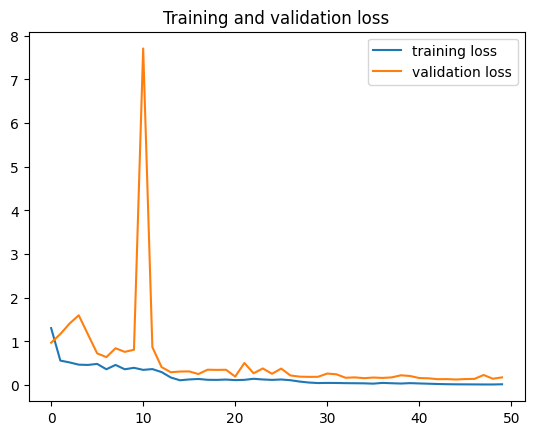

In [32]:
#@title Graphing accuracy and loss

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss =history.history['loss']
val_loss =history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [33]:
model.save("/content/drive/MyDrive/new/bestsign.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/new/bestsign.h5')

In [35]:
print("Accuracy of the model is - " , model.evaluate(x_test_resized, y_test)[1]*100 , "%")

225/225 [==============================] - 2s 6ms/step - loss: 0.1769 - accuracy: 0.9635
Accuracy of the model is -  96.34690284729004 %


225/225 [==============================] - 1s 3ms/step


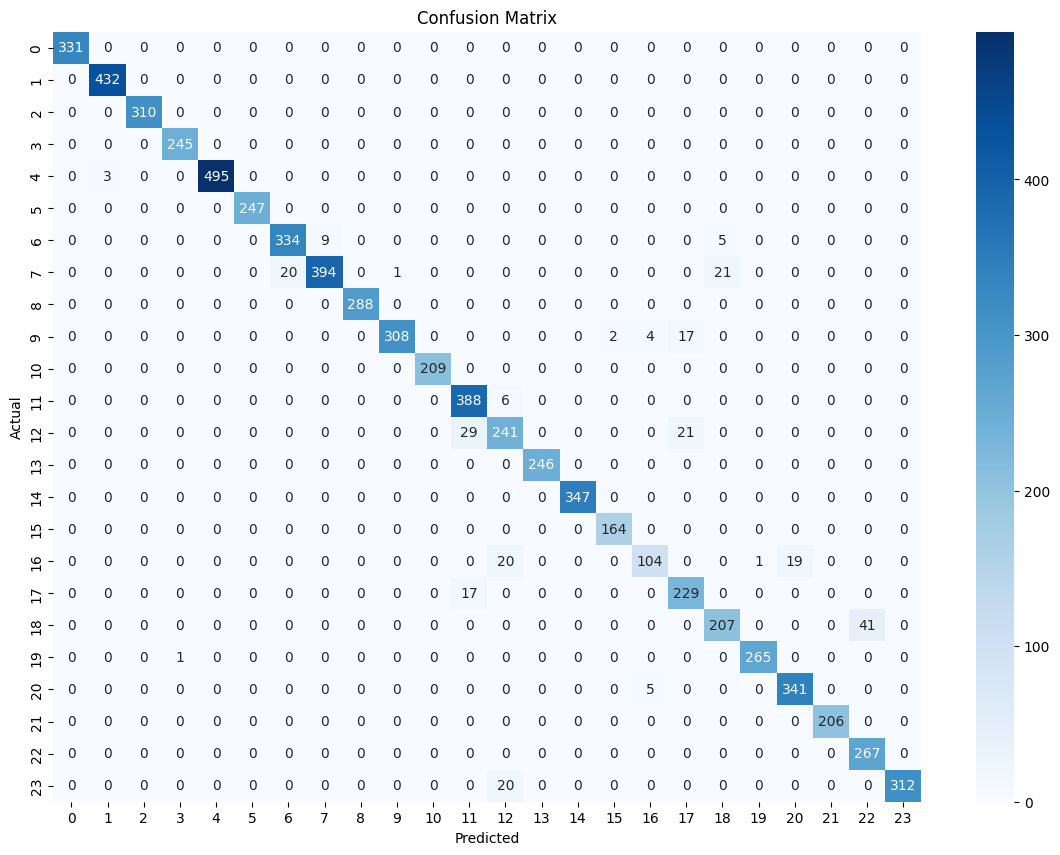

In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(24), yticklabels=range(24))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/new/bestsign.h5')  # Replace with your actual model path

# Define function to preprocess image
def preprocess_image(image_path):
    # Load image from file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize image to match model input size (assuming 28x28)
    img = cv2.resize(img, (64, 64))

    # Normalize pixel values to range 0-1
    img = img / 255.0

    # Reshape image to match input shape expected by the model
    img = img.reshape(1, 64, 64, 1)

    return img

# Define function to predict sign language gesture and display image
def predict_and_display(image_path):
    # Preprocess image
    img = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(img)

    # Get predicted class index
    predicted_class_index = np.argmax(prediction)

    # Map class index to class name (assuming classes are ['A', 'B', 'C', ..., 'Y'])
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
    predicted_class_name = classes[predicted_class_index]

    # Load and display image using Matplotlib
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.axis('off')
    plt.show()



1/1 [==============================] - 0s 31ms/step


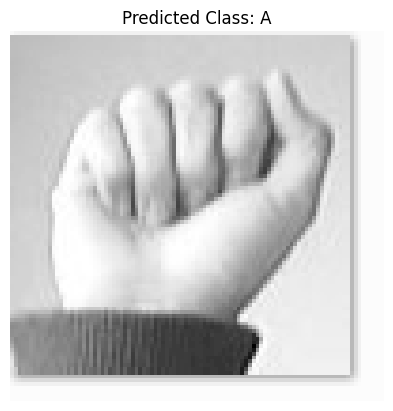

In [39]:
# Example usage:
image_path = '/content/drive/MyDrive/FINAL/a.png'  # Replace with your image path
predict_and_display(image_path)


1/1 [==============================] - 0s 49ms/step


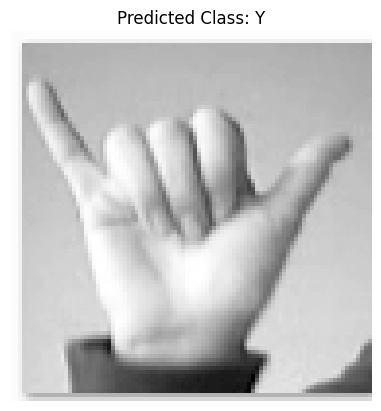

In [40]:
# Example usage:
image_path = '/content/drive/MyDrive/FINAL/y.png'  # Replace with your image path
predict_and_display(image_path)
